<a href="https://colab.research.google.com/github/anacgfp/ExemploCompilador/blob/master/ga_desafio_CN_2020_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Você deverá construir um modelo, utilizando Algoritmo Genético, para resolver a demanda de entregas das Lojas do Recife. Porém, este seu modelo deve seguir a lógica do Problema do Caixeiro Viajante (PCV), onde é preciso determinar a menor rota para percorrer uma série de cidades (visitando uma única vez cada uma delas), e retornar à cidade de origem.

**Considerações**



1.   A função de aptidão (fitness) será 1 / d, onde “d” é a distância total percorrida.
2.   A distância pode ser calculada usando a distância euclidiana entre as cidades.
3.   A sua solução deve sempre gerar rotas sintaticamente corretas, isto é, as rotas devem visitar cada cidade apenas uma vez, retornando à cidade de origem.



**Entrega**

Você deverá entregar um relatório contendo:
1. Comparação entre os resultados obtidos pelos diferentes métodos de seleção (roleta, torneio e elitismo);
2. Validar ao menos dois operadores de crossover e comentar seus resultados;
3. Validar ao menos dois operadores de mutação e comentar seus resultados;
4. Exibir a Rota Final


In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib as mplib
import random

In [2]:
#Problem representation 
bairros_list = ["Aflitos",
"Casa Amarela",
"Casa Forte",
"Campo Grande",
"Boa Viagem",
"Piedade",
"Cidade Universitária",
"Derby",
"Encruzilhada",
"Ibura"]
x_list = [50,140,110,30,240,400,330,80,30,280]
y_list = [60,78,55,108,378,128,256,15,20,12]

In [3]:
class Bairro:
  def __init__(self, nome, x, y):
    self.nome = nome
    self.x = x
    self.y = y

#euclidian distance between two neighborhoods
  def get_dist(self, bairro):
    return math.sqrt((bairro.x - self.x)**2 + (bairro.y - self.y)**2)
  
  def print_bairro(self):
    print(self.nome, ' ', self.x, ' ', self.y)

In [4]:
def inicializar_bairros():
  bairros = []
  for i in range(0, len(bairros_list)):
    bairros.append(Bairro(bairros_list[i], x_list[i], y_list[i]))
  return bairros
# for i in inicializar_bairros():
#   i.print_bairro()
BAIRROS = inicializar_bairros()

In [5]:
#parameters and constants
TWO = 2

pop_size = 10
pm = 0.1
selection_op = 'elitism'
crossover_op = 'single point'
mutation_op = 'random' 

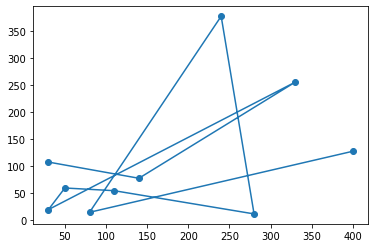

In [6]:
class Individual:
  def __init__(self, BAIRROS):
    self.bairros = random.sample(BAIRROS, len(BAIRROS))
    self.fitness = self.get_fitness()

  #Calculating the fitness of the the individual (route)
  def get_fitness(self):
    distance = 0
    for i in range(0, len(self.bairros)):
      if(i == len(self.bairros) -1):
        distance += self.bairros[i].get_dist(self.bairros[0])
      else:
        distance += self.bairros[i].get_dist(self.bairros[i+1])
    return 1/distance

  #printing individuals
  def print_ind(self):
    for i in self.bairros:
     i.print_bairro()
    
  #plotting individuals
  def plot_ind(self):
    aux_x = []
    aux_y = []
    for i in self.bairros:
      aux_x.append(i.x)
      aux_y.append(i.y)
    mplib.pyplot.scatter(aux_x, aux_y) 
    mplib.pyplot.plot(aux_x, aux_y) 


Individual(BAIRROS).plot_ind()

In [7]:
#generate the population
class Population:
  def __init__(self, pop_size, pop_list):
    self.pop = pop_list


  def get_best(self):
    best_individual = self.pop[0]
    for i in self.pop:
      if i.get_fitness() > best_individual.get_fitness():
        best_individual = i
    return best_individual

  def print_pop(self):
    for i in self.pop:
      i.print_ind()
      print('------------------------------------------')


# population = Population(pop_size)
# population.get_best().print_ind()
#population.print_pop()

In [8]:
#selection operators - roulette
# BEGIN
# /* Given the cumulative probability distribution a */
# /* and assuming we wish to select λ members of the mating pool */
# set current member = 1;
# WHILE ( current member ≤ λ ) DO
# Pick a random value r uniformly from [0, 1];
# set i = 1;
# WHILE ( a i < r ) DO
# set i = i + 1;
# OD
# set mating pool[current member] = parents[i];
# set current member = current member + 1;
# OD
# END
def get_fitness_list(pop):
  fitness_list = []
  for i in range(0, pop_size):
    fitness_list.append(pop.pop[i].get_fitness())
  return fitness_list


def get_prob_distr(pop, fitness_list):
  prob_distr = []
  a = 0
  total_fitness = sum(fitness_list)
  for i in fitness_list:
    a += i/total_fitness
    prob_distr.append(a)
  return prob_distr

pop = []
for _ in range(0, pop_size):
  pop.append(Individual(BAIRROS))
population = Population(pop_size, pop)
fitness_list = get_fitness_list(population)
prob_distr = get_prob_distr(population, fitness_list)

def roulette(population, number_parents, prob_distr):
  parents = []
  n = 0
  while n < number_parents:
    r = random.random()
    i = 0
    while  prob_distr[i] < r:
      i += 1
    parents.append( population.pop[i])
    n += 1
  return parents

#test
roulette(population, TWO, prob_distr)

In [9]:
#selection operators - tournament
# BEGIN
# /* Assume we wish to select λ members of a pool of μ individuals */
# set current member = 1;
# WHILE ( current member ≤ λ ) DO
# Pick k individuals randomly, with or without replacement;
# Compare these k individuals and select the best of them;
# Denote this individual as i;
# set mating pool[current member] = i;
# set current member = current member + 1;
# OD
# END
def tournament(pop, n_parents, k):
  current_member = 1
  mating_pool = []
  while current_member <= n_parents:
    new_pop = Population(k, random.sample(pop, k))
    best = new_pop.get_best()
    mating_pool.append(best)
    current_member += 1
  return mating_pool

print(tournament(population.pop, TWO, 10))
#selection operators - elitism
#keeps the best individual of each generation, and the rest is done in "classical" way? 
#returns the list without the best, because it will be keeped anyway
#reproduz aleatoriamente e pega os melhores
# @ TODO
def elitism(population, n_parents):
  mating_pool = population.pop.copy()
  mating_pool.remove(population.get_best())
  return mating_pool

print(elitism(population, TWO))

[<__main__.Individual object at 0x7fbe6ca403c8>, <__main__.Individual object at 0x7fbe6ca403c8>]
[<__main__.Individual object at 0x7fbe6ca40a58>, <__main__.Individual object at 0x7fbe6ca40ba8>, <__main__.Individual object at 0x7fbe6ca40be0>, <__main__.Individual object at 0x7fbe6ca40d68>, <__main__.Individual object at 0x7fbe6ca40e80>, <__main__.Individual object at 0x7fbe6ca40d30>, <__main__.Individual object at 0x7fbe6ca40ef0>, <__main__.Individual object at 0x7fbe6ca40320>, <__main__.Individual object at 0x7fbe6ca40668>]


In [10]:
#reproduction operators - crossover 
# Procedure: OX
# 1. Select a substring from a parent at random.
# 2. Produce a proto-child by copying the substring into the
# corresponding position of it.
# 3. Delete the cities which are already in the substring from the 2nd
# parent. The resulted sequence of citires contains the cities that the
# proto-child needs.
# 4. Place the cities into the unfixed positions of the proto-child from left
# to right according to the order of the sequence to produce an
# offspring.
def order_crossover(parent1, parent2):
  

SyntaxError: ignored

In [ ]:
#reproduction operators - mutation